In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader, Dataset, Subset, random_split
from PIL import Image
from torchvision.datasets import ImageFolder
from tqdm import tqdm
import numpy as np
from torchvision.models import resnet50
from torch.autograd import Variable
import os
import pandas as pd
from sklearn.model_selection import train_test_split


In [ ]:
# Check if GPU is available and set device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
transform = transforms.Compose([
    transforms.RandomRotation(15),  # Rotation by ±15 degrees
    transforms.RandomHorizontalFlip(),  # Horizontal flip
    transforms.RandomVerticalFlip(),  # Uncomment if vertical flip is desired
    transforms.ToTensor(),  # Convert images to tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize the images
])

# transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize the image data
# ])

In [ ]:
# Load CIFAR-10 dataset
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2)

testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=32, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
class CNN1(nn.Module):
    def __init__(self, num_classes=10):
        super(CNN1, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=96, kernel_size=5, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(num_features=96)
        self.conv2 = nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, stride=1, padding=0)
        self.bn2 = nn.BatchNorm2d(num_features=256)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv3 = nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(in_features=256 * 12 * 12, out_features=num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool1(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.fc1(x)
        x = F.softmax(x, dim=1)  # Apply softmax to convert to probability distribution
        return x

In [ ]:
# Training loop
def train(epoch, net, trainloader, optimizer, criterion):
    net.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)  # Move data to GPU
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # Compute accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        if i % 2000 == 1999:  # Print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

    # Calculate accuracy after each epoch
    accuracy = 100 * correct / total
    epoch_list.append(epoch + 1)  # Append epoch number to list
    accuracy_list.append(accuracy)  # Append accuracy to list
    print('Epoch [%d], Accuracy on training images: %d %%' % (epoch + 1, accuracy))

In [ ]:
# Test the model
def test(net, testloader):
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)  # Move data to GPU
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print('Accuracy on test images: %d %%' % (100 * correct / total))


In [ ]:
# Initialize the model and move it to the GPU
net = CNN1().to(device)
# # Print the shape of the tensor after the convolutional layers
# input_tensor = torch.randn(64, 3, 32, 32)  # Assuming CIFAR-10 input size
# conv_output = net(input_tensor)
# print(conv_output.shape)
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=0.001)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
# optimizer = optim.Adam(net.parameters(), lr=0.001)


In [ ]:
# Lists to store epoch and accuracy values
epoch_list = []
accuracy_list = []

# Train the model
for epoch in range(10):  # loop over the dataset multiple times
    train(epoch, net, trainloader, optimizer, criterion)

test(net, testloader)

Epoch [1], Accuracy on training images: 38 %
Epoch [2], Accuracy on training images: 50 %
Epoch [3], Accuracy on training images: 56 %
Epoch [4], Accuracy on training images: 60 %
Epoch [5], Accuracy on training images: 64 %
Epoch [6], Accuracy on training images: 66 %
Epoch [7], Accuracy on training images: 68 %
Epoch [8], Accuracy on training images: 70 %
Epoch [9], Accuracy on training images: 71 %
Epoch [10], Accuracy on training images: 72 %
Accuracy on test images: 71 %


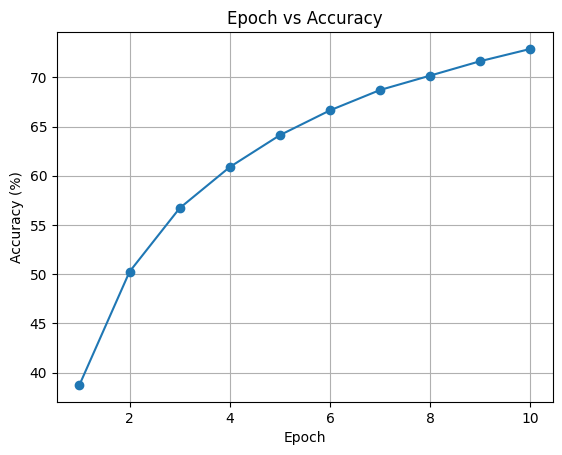

In [ ]:
import matplotlib.pyplot as plt
# Plot epoch vs accuracy
plt.plot(epoch_list, accuracy_list, marker='o')
plt.title('Epoch vs Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.show()